# Latent Dirichlet Allocation - Advanced Machine Learning

 ## Import Libraries and Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Gensim is a Python library for topic modelling, document indexing and similarity retrieval with large corpora.
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess

#The Natural Language Toolkit (NLTK) is a platform used for building Python programs that work with 
# human language data for applying in statistical natural language processing (NLP). 

# It contains text processing libraries for tokenization, parsing, 
# classification, stemming, tagging and semantic reasoning

import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import RegexpTokenizer

from nltk.corpus import stopwords
nltk.download('stopwords')
stop=set(stopwords.words('english'))
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

# Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import CountVectorizer

# Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.feature_extraction.text import TfidfVectorizer

# This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). 
# Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. 
# This means it can work with sparse matrices efficiently.
from sklearn.decomposition import TruncatedSVD

# The main goal of this python notebook: Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation

# T-distributed Stochastic Neighbor Embedding.
from sklearn.manifold import TSNE

try:
    import pyLDAvis
    import pyLDAvis.lda_model  
    pyLDAvis.enable_notebook()
except:
    !pip install pyLDAvis
    import pyLDAvis
    import pyLDAvis.lda_model  
    pyLDAvis.enable_notebook()


from collections import  Counter

try:
    from wordcloud import WordCloud
except:
    !pip install wordcloud
    from wordcloud import WordCloud

# Stop warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shiqing\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Shiqing\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shiqing\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shiqing\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# A New York Times dataset (Year 2018 - 2022)
df = pd.read_csv("data/nyt_clean.csv")

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256136 entries, 0 to 256135
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   abstract        256136 non-null  object 
 1   lead_paragraph  256136 non-null  object 
 2   headline        256136 non-null  object 
 3   pub_date        256136 non-null  object 
 4   section_name    256136 non-null  object 
 5   byline          256136 non-null  object 
 6   word_count      256136 non-null  float64
 7   year            256136 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 15.6+ MB


abstract  \
0  american health care is a universe of scientif...   
1  the costa rican government said the crash occu...   
2  families have turned the side of a warehouse f...   
3  making new year resolutions as a hedge against...   
4  the outpouring of support after new york’s dea...   

                                      lead_paragraph  \
0  president trump is vowing to return to two of ...   
1  in the weeks before their family trip to costa...   
2  maria stood outside the metropolitan detention...   
3  nashville — two weeks ago i was reading a book...   
4  minutes before sunday mass at st. martin of to...   

                                            headline  \
0  {'main': 'Tom Brokaw: You Can Find the Entire ...   
1  {'main': 'New York Family of 5 Among 10 Americ...   
2  {'main': 'The Wall of Love Outside a Jail', 'k...   
3  {'main': 'The Sentient-Being Diet', 'kicker': ...   
4  {'main': 'Overwhelmed by Donations for Survivo...   

                    pub_date section_name  \
0  2018-01-01 00:02:50+00:00      Opinion   
1  2018-01-01 00:10:52+00:00        World   
2  2018-01-01 00:13:23+00:00     New York   
3  2018-01-01 00:16:41+00:00      Opinion   
4  2018-01-01 00:26:45+00:00     New York   

                                              byline  word_count  year  
0  {'original': 'By Tom Brokaw', 'person': [{'fir...       747.0  2018  
1  {'original': 'By Matthew Haag', 'person': [{'f...       909.0  2018  
2  {'original': 'By Annie Correal', 'person': [{'...      1503.0  2018  
3  {'original': 'By Margaret Renkl', 'person': [{...       928.0  2018  
4  {'original': 'By Luis Ferré-Sadurní', 'person'...       719.0  2018

In [4]:
df['section_name'].nunique()

58

 ## Preprocess and Explore Data

In [5]:
""" We will explore the Abstract and Lead Paragraph column one-by-one """

' We will explore the Abstract and Lead Paragraph column one-by-one '

In [6]:
# Counting how many headline each section have 
New_section_type = df.groupby('section_name').count()['headline'].reset_index()
New_section_type = New_section_type.sort_values(by='headline', ascending=False)
# New_section_type
top_30_section = New_section_type.head(30)
top_30_section_names = top_30_section['section_name'].tolist()
top_30 = df[df['section_name'].isin(top_30_section_names)]

In [7]:
import plotly.express as px

section_counts = top_30.groupby("section_name").count()["headline"].reset_index()

section_counts['color'] = section_counts['headline'].apply(lambda x: 'red' if x > 7000 else 'blue')

fig = px.scatter(section_counts, x="section_name", y="headline", size="headline", title="Headline based on each section",
                 labels={"headline": "Number of Headlines", "section_name": "Section Name"},
                 size_max=50, color='color')  # Set the color parameter to the new 'color' column

fig.show()

In [8]:
print("We will explore the World section for the abstract column and Travel section for lead paragraph column-->")

We will explore the World section for the abstract column and Travel section for lead paragraph column-->


In [20]:
data1 = df[df['section_name'].isin(['World', 'Sports', 'Arts', 'Food'])]
data1.shape

(70903, 8)

In [21]:
import textwrap

text = """The exploratory analysis focuses on word frequency, sentence length, average word length analysis, which will help to understand the fundamental characteristics of the text data.

The chart shows nouns that should be no separated as a word single, such as Trump showing a separate word. The next stage will use the Ngram method to solve the problem and mix the words that have the same meaning into one.

Ngrams are defined as contiguous sequences of n words. If the number of words has the same meaning as Donald Trump, it's called Bigram, and if it's more than two words, then it's considered as a trigram.

The chart above shows the top 20 bigrams in the news headline, which is the most frequent words after removing stop words and lemmatization. Comparing the former one, we can see the words more meaningful and not repeated twice, but there still duplicate words in different deadlines. Using bigrams could improve our data retrieval to be more meaningful, but we still need to improve it."""

wrapped_text = textwrap.fill(text, width=80)  # Adjust the width as needed

print(wrapped_text)

The exploratory analysis focuses on word frequency, sentence length, average
word length analysis, which will help to understand the fundamental
characteristics of the text data.  The chart shows nouns that should be no
separated as a word single, such as Trump showing a separate word. The next
stage will use the Ngram method to solve the problem and mix the words that have
the same meaning into one.  Ngrams are defined as contiguous sequences of n
words. If the number of words has the same meaning as Donald Trump, it's called
Bigram, and if it's more than two words, then it's considered as a trigram.  The
chart above shows the top 20 bigrams in the news headline, which is the most
frequent words after removing stop words and lemmatization. Comparing the former
one, we can see the words more meaningful and not repeated twice, but there
still duplicate words in different deadlines. Using bigrams could improve our
data retrieval to be more meaningful, but we still need to improve it.


In [22]:
text = """Data cleaning is absolutely crucial for generating a useful topic model: as the saying goes, “garbage in, garbage out.” The steps below are common to most natural language processing methods:

 - Tokenizing: converting a document to its atomic elements.
 - Stopping: removing meaningless words.
 - Lemmatization: Lemmatization is the process of grouping together different inflected forms of the same word."""

paragraphs = text.split('\n')

wrapped_paragraphs = [textwrap.fill(paragraph, width=80) for paragraph in paragraphs]

wrapped_text = '\n'.join(wrapped_paragraphs)

print(wrapped_text)

Data cleaning is absolutely crucial for generating a useful topic model: as the
saying goes, “garbage in, garbage out.” The steps below are common to most
natural language processing methods:

 - Tokenizing: converting a document to its atomic elements.
 - Stopping: removing meaningless words.
 - Lemmatization: Lemmatization is the process of grouping together different
inflected forms of the same word.


#### Punctuation Cleaning, Tokenization and Lemmatization

In [23]:
#function to count the number of words in the article
def word_count(article):
  return len(article.split(" "))

In [24]:
# Getting word count of each abstract
data1['word_count']=data1['abstract'].apply(word_count) 

In [25]:
#Total number of words present in the whole abstract corpus 
Total_words1=sum(data1['word_count'])
Total_words1

1689804

In [26]:
#print the sixteenth abstract
data1['abstract'].iloc[15]

'the oakland raiders, detroit lions, indianapolis colts, chicago bears and arizona cardinals are looking for new leadership.'

In [27]:
#removing punctuation from the sixteenth abstract
import string
text_without_punctuation = ''.join([char for char in data1['abstract'].iloc[15] if char not in ('"', '“', ',' '”', "'", "—", "’", '.') and char not in string.punctuation])
text_without_punctuation

#added extra characters in the punctuation as “ != ", similarly for other characters

'the oakland raiders detroit lions indianapolis colts chicago bears and arizona cardinals are looking for new leadership'

In [28]:
# tokenizing the sixteenth abstract

# initializing word tokenizer
word_list  = word_tokenize(text_without_punctuation)
word_list

['the',
 'oakland',
 'raiders',
 'detroit',
 'lions',
 'indianapolis',
 'colts',
 'chicago',
 'bears',
 'and',
 'arizona',
 'cardinals',
 'are',
 'looking',
 'for',
 'new',
 'leadership']

In [29]:
# lemmatizing the sixteenth abstract

lemma = WordNetLemmatizer()
word_list = [lemma.lemmatize(word) for word in word_list]
word_list

['the',
 'oakland',
 'raider',
 'detroit',
 'lion',
 'indianapolis',
 'colt',
 'chicago',
 'bear',
 'and',
 'arizona',
 'cardinal',
 'are',
 'looking',
 'for',
 'new',
 'leadership']

In [30]:
""" Notice the changes in the words post lemmatizing"""

' Notice the changes in the words post lemmatizing'

In [31]:
#Defining a combined function for all three steps above

def lemmatize_word(text):
    text_without_punctuation = ''.join([char for char in text if char not in ('"', '“', '”', "'", "—", "’", '.') and char not in string.punctuation])
    word_list = word_tokenize(text_without_punctuation)
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    return ' '.join(word_list)

In [32]:
#Applying lemmatization on the 'abstract' column which will be called as corpus hereafter
data1['abstract']=data1['abstract'].apply(lemmatize_word)

In [33]:
data1.head()

abstract  \
1   the costa rican government said the crash occu...   
11  can buffalo build on it stunning arrival in th...   
12  he proposed talk with south korea to discus th...   
14  a year after a livetelevision debacle the pop ...   
15  pbs independent lens series feature a portrait...   

                                       lead_paragraph  \
1   in the weeks before their family trip to costa...   
11  the n.f.l. regular season ended with some dram...   
12  seoul, south korea — north korea’s leader, kim...   
14  this time, there were no malfunctions. and the...   
15  the independent lens series features a portrai...   

                                             headline  \
1   {'main': 'New York Family of 5 Among 10 Americ...   
11  {'main': 'N.F.L. Wild-Card Picks: Rams Over Fa...   
12  {'main': 'Kim Jong-un Offers North Korea’s Han...   
14  {'main': 'Mariah Carey Redeems Herself on New ...   
15  {'main': 'What’s on TV Monday: ‘The Untold Tal...   

                     pub_date section_name  \
1   2018-01-01 00:10:52+00:00        World   
11  2018-01-01 02:26:58+00:00       Sports   
12  2018-01-01 03:01:30+00:00        World   
14  2018-01-01 05:59:40+00:00         Arts   
15  2018-01-01 06:00:04+00:00         Arts   

                                               byline  word_count  year  
1   {'original': 'By Matthew Haag', 'person': [{'f...          27  2018  
11  {'original': 'By Benjamin Hoffman', 'person': ...          18  2018  
12  {'original': 'By Choe Sang-Hun', 'person': [{'...          25  2018  
14  {'original': 'By Sopan Deb', 'person': [{'firs...          17  2018  
15  {'original': 'By Sara Aridi', 'person': [{'fir...          20  2018

[Text(0.5, 1.0, 'Top 20 most frequent words in the corpus')]

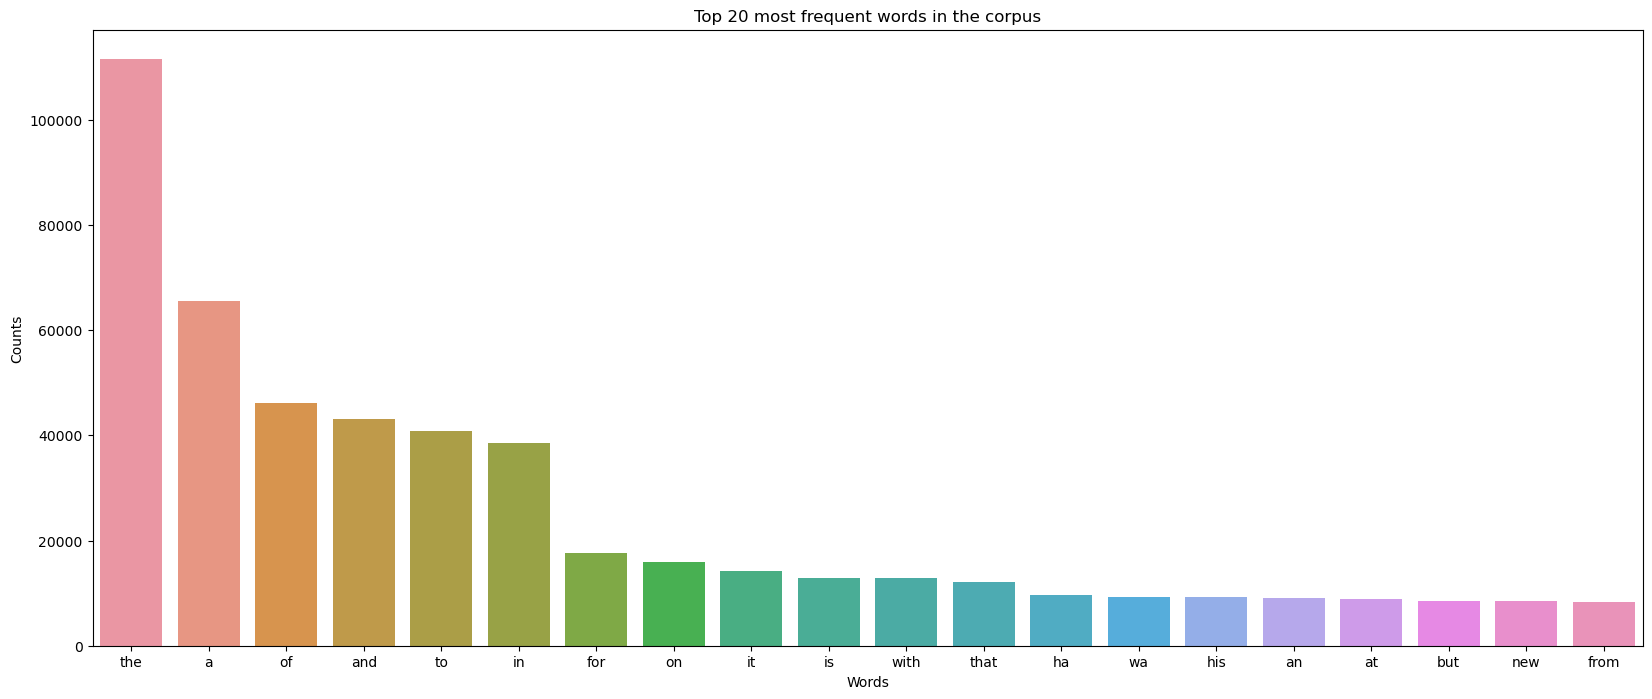

In [34]:
#Top 20 most frequent words in the corpus (abstract)
Top_20_freq = pd.Series(' '.join(data1['abstract']).split()).value_counts()[:20]
top20=pd.DataFrame()
top20['Words']= list(Top_20_freq.index)
top20['Counts']=list(Top_20_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top20,ax=ax).set(title='Top 20 most frequent words in the corpus')

#### Removing short length words ( length less than 3)

In [35]:
#Removing short length words ( length less than 3)
def short_length(text):
  return (' '.join([wds for wds in text.split() if len(wds)>2]))

data1['abstract']=data1['abstract'].apply(short_length)

In [36]:
# Total number of words present in the whole corpus
Total_words1 = sum(data1['word_count'])
Total_words1

1689804

In [37]:
# Word count after removal of short length
data1['wc_rem_short_len']=data1['abstract'].apply(word_count) 
display(data1.head())

abstract  \
1   the costa rican government said the crash occu...   
11  can buffalo build stunning arrival the playoff...   
12  proposed talk with south korea discus the nort...   
14  year after livetelevision debacle the pop supe...   
15  pbs independent lens series feature portrait t...   

                                       lead_paragraph  \
1   in the weeks before their family trip to costa...   
11  the n.f.l. regular season ended with some dram...   
12  seoul, south korea — north korea’s leader, kim...   
14  this time, there were no malfunctions. and the...   
15  the independent lens series features a portrai...   

                                             headline  \
1   {'main': 'New York Family of 5 Among 10 Americ...   
11  {'main': 'N.F.L. Wild-Card Picks: Rams Over Fa...   
12  {'main': 'Kim Jong-un Offers North Korea’s Han...   
14  {'main': 'Mariah Carey Redeems Herself on New ...   
15  {'main': 'What’s on TV Monday: ‘The Untold Tal...   

                     pub_date section_name  \
1   2018-01-01 00:10:52+00:00        World   
11  2018-01-01 02:26:58+00:00       Sports   
12  2018-01-01 03:01:30+00:00        World   
14  2018-01-01 05:59:40+00:00         Arts   
15  2018-01-01 06:00:04+00:00         Arts   

                                               byline  word_count  year  \
1   {'original': 'By Matthew Haag', 'person': [{'f...          27  2018   
11  {'original': 'By Benjamin Hoffman', 'person': ...          18  2018   
12  {'original': 'By Choe Sang-Hun', 'person': [{'...          25  2018   
14  {'original': 'By Sopan Deb', 'person': [{'firs...          17  2018   
15  {'original': 'By Sara Aridi', 'person': [{'fir...          20  2018   

    wc_rem_short_len  
1                 23  
11                14  
12                19  
14                13  
15                16

In [38]:
"""Notice the word_count and wc_rem_short_len columns in the above dataset"""

'Notice the word_count and wc_rem_short_len columns in the above dataset'

#### Removing Stopwords

In [39]:
#Stopwords

# list of stopwords from nltk
stopwords_nltk = list(stopwords.words('english'))

# # list of stopwords from spacy
# sp = spacy.load('en_core_web_sm')
# stopwords_spacy = list(sp.Defaults.stop_words)

# list of stopwords from gensim
stopwords_gensim = list(gensim.parsing.preprocessing.STOPWORDS)

# unique stopwords from all stopwords
all_stopwords = []
all_stopwords.extend(stopwords_nltk)
# all_stopwords.extend(stopwords_spacy)
all_stopwords.extend(stopwords_gensim)

# all unique stop words
all_stopwords = list(set(all_stopwords))

def stop_words(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in all_stopwords]
  return " ".join(text)
len(all_stopwords)

390

In [40]:
#Removal of Stopwords
data1['abstract']=data1['abstract'].apply(stop_words)
# word count after removing the stopwords
data1['after_stop']=data1['abstract'].apply(word_count)
data1.head() 

abstract  \
1   costa rican government said crash occurred mou...   
11  buffalo build stunning arrival playoff falcon ...   
12  proposed talk south korea discus north partici...   
14  year livetelevision debacle pop superstar got ...   
15  pbs independent lens series feature portrait w...   

                                       lead_paragraph  \
1   in the weeks before their family trip to costa...   
11  the n.f.l. regular season ended with some dram...   
12  seoul, south korea — north korea’s leader, kim...   
14  this time, there were no malfunctions. and the...   
15  the independent lens series features a portrai...   

                                             headline  \
1   {'main': 'New York Family of 5 Among 10 Americ...   
11  {'main': 'N.F.L. Wild-Card Picks: Rams Over Fa...   
12  {'main': 'Kim Jong-un Offers North Korea’s Han...   
14  {'main': 'Mariah Carey Redeems Herself on New ...   
15  {'main': 'What’s on TV Monday: ‘The Untold Tal...   

                     pub_date section_name  \
1   2018-01-01 00:10:52+00:00        World   
11  2018-01-01 02:26:58+00:00       Sports   
12  2018-01-01 03:01:30+00:00        World   
14  2018-01-01 05:59:40+00:00         Arts   
15  2018-01-01 06:00:04+00:00         Arts   

                                               byline  word_count  year  \
1   {'original': 'By Matthew Haag', 'person': [{'f...          27  2018   
11  {'original': 'By Benjamin Hoffman', 'person': ...          18  2018   
12  {'original': 'By Choe Sang-Hun', 'person': [{'...          25  2018   
14  {'original': 'By Sopan Deb', 'person': [{'firs...          17  2018   
15  {'original': 'By Sara Aridi', 'person': [{'fir...          20  2018   

    wc_rem_short_len  after_stop  
1                 23          18  
11                14           9  
12                19          13  
14                13           9  
15                16          12

In [41]:
"""Notice the after_stop column and the reduction of the number of stop words. """

'Notice the after_stop column and the reduction of the number of stop words. '

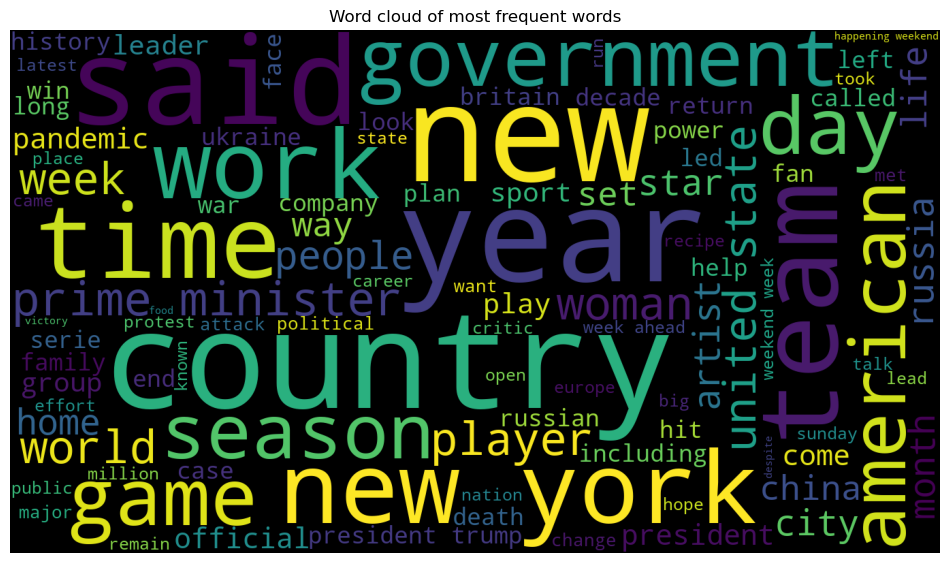

In [42]:
# Cloud Words plot for displaying most frequent words in the corpus (abstract)
freq_words = ','.join(list(data1['abstract'].values))

wordcloud = WordCloud(width=1366, height=768, random_state=21,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Word cloud of most frequent words')
plt.axis('off')
plt.show()

#### Removing of non-contextual words

In [43]:
#removal of non-contextual words
add_stopwords= ['said','told','called','use','know','came','based','way','added','including','got','week','people','year','new','mr.']
#Function to remove additional stopwords 
def remove_add_stopwords(text):
  text = [wd.lower() for wd in text.split() if wd.lower() not in add_stopwords]
  return " ".join(text)
#Removing additional stopwords according to use case
data1['abstract']=data1['abstract'].apply(remove_add_stopwords)
# word count after removing the additional stopwords
data1['wc_rem_stopword']=data1['abstract'].apply(word_count)
data1.head()   

abstract  \
1   costa rican government crash occurred mountain...   
11  buffalo build stunning arrival playoff falcon ...   
12  proposed talk south korea discus north partici...   
14  livetelevision debacle pop superstar twosong p...   
15  pbs independent lens series feature portrait w...   

                                       lead_paragraph  \
1   in the weeks before their family trip to costa...   
11  the n.f.l. regular season ended with some dram...   
12  seoul, south korea — north korea’s leader, kim...   
14  this time, there were no malfunctions. and the...   
15  the independent lens series features a portrai...   

                                             headline  \
1   {'main': 'New York Family of 5 Among 10 Americ...   
11  {'main': 'N.F.L. Wild-Card Picks: Rams Over Fa...   
12  {'main': 'Kim Jong-un Offers North Korea’s Han...   
14  {'main': 'Mariah Carey Redeems Herself on New ...   
15  {'main': 'What’s on TV Monday: ‘The Untold Tal...   

                     pub_date section_name  \
1   2018-01-01 00:10:52+00:00        World   
11  2018-01-01 02:26:58+00:00       Sports   
12  2018-01-01 03:01:30+00:00        World   
14  2018-01-01 05:59:40+00:00         Arts   
15  2018-01-01 06:00:04+00:00         Arts   

                                               byline  word_count  year  \
1   {'original': 'By Matthew Haag', 'person': [{'f...          27  2018   
11  {'original': 'By Benjamin Hoffman', 'person': ...          18  2018   
12  {'original': 'By Choe Sang-Hun', 'person': [{'...          25  2018   
14  {'original': 'By Sopan Deb', 'person': [{'firs...          17  2018   
15  {'original': 'By Sara Aridi', 'person': [{'fir...          20  2018   

    wc_rem_short_len  after_stop  wc_rem_stopword  
1                 23          18               17  
11                14           9                9  
12                19          13               13  
14                13           9                7  
15                16          12               12

[Text(0.5, 1.0, 'Top 20 most frequent words in the corpus After stopword removal')]

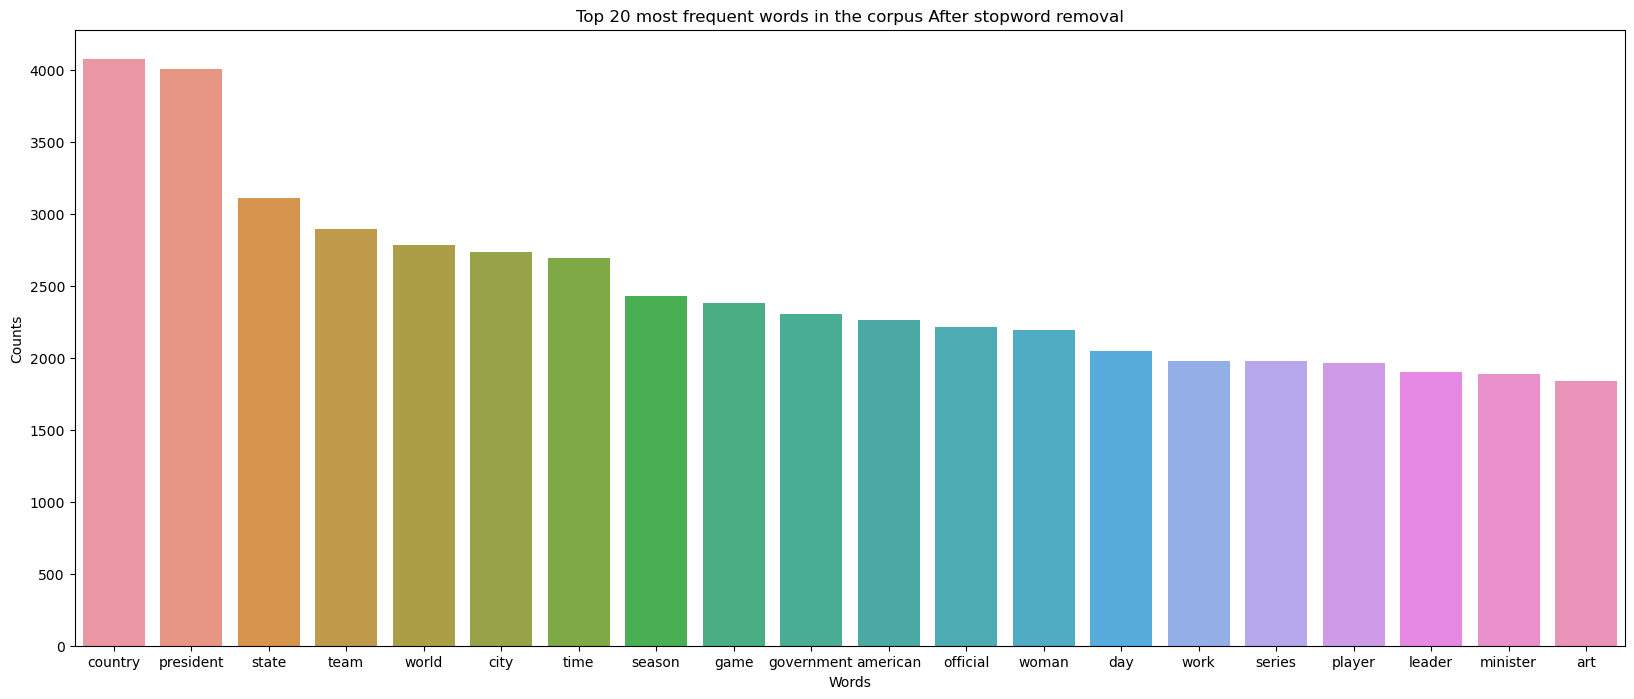

In [44]:
#Top 20 most frequent words in the corpus After stopword removal
Top_20_freq = pd.Series(' '.join(data1['abstract']).split()).value_counts()[:20]
top20=pd.DataFrame()
top20['Words']= list(Top_20_freq.index)
top20['Counts']=list(Top_20_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top20,ax=ax).set(title='Top 20 most frequent words in the corpus After stopword removal')

In [45]:
"""Notice that the top 20 words have more context"""

'Notice that the top 20 words have more context'

#### Visualization of top 20 bi-gram & tri-gram

In [46]:
def get_top_n_gram(corpus, ngram, n=20):

    ''' 
    This functions takes entire corpus and returns list of tuple in  pair words and number of its occurence.
    '''
    # creates instance of count vectorizer for n-grams
    vec = CountVectorizer(ngram_range=(ngram,ngram)).fit(corpus)

    # returns sparse matrix of index as documents and columns as Bow as features
    bag_of_words = vec.transform(corpus)

    # returns 2D array with count of features in corpus
    sum_words = bag_of_words.sum(axis=0) 

    # returns list of tuples with text,counts pair
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    # sort the list of tuples by its number of occurence
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    # returns list of tuples top n words
    return words_freq[:n]

[Text(0.5, 1.0, 'Top 20 bigram words')]

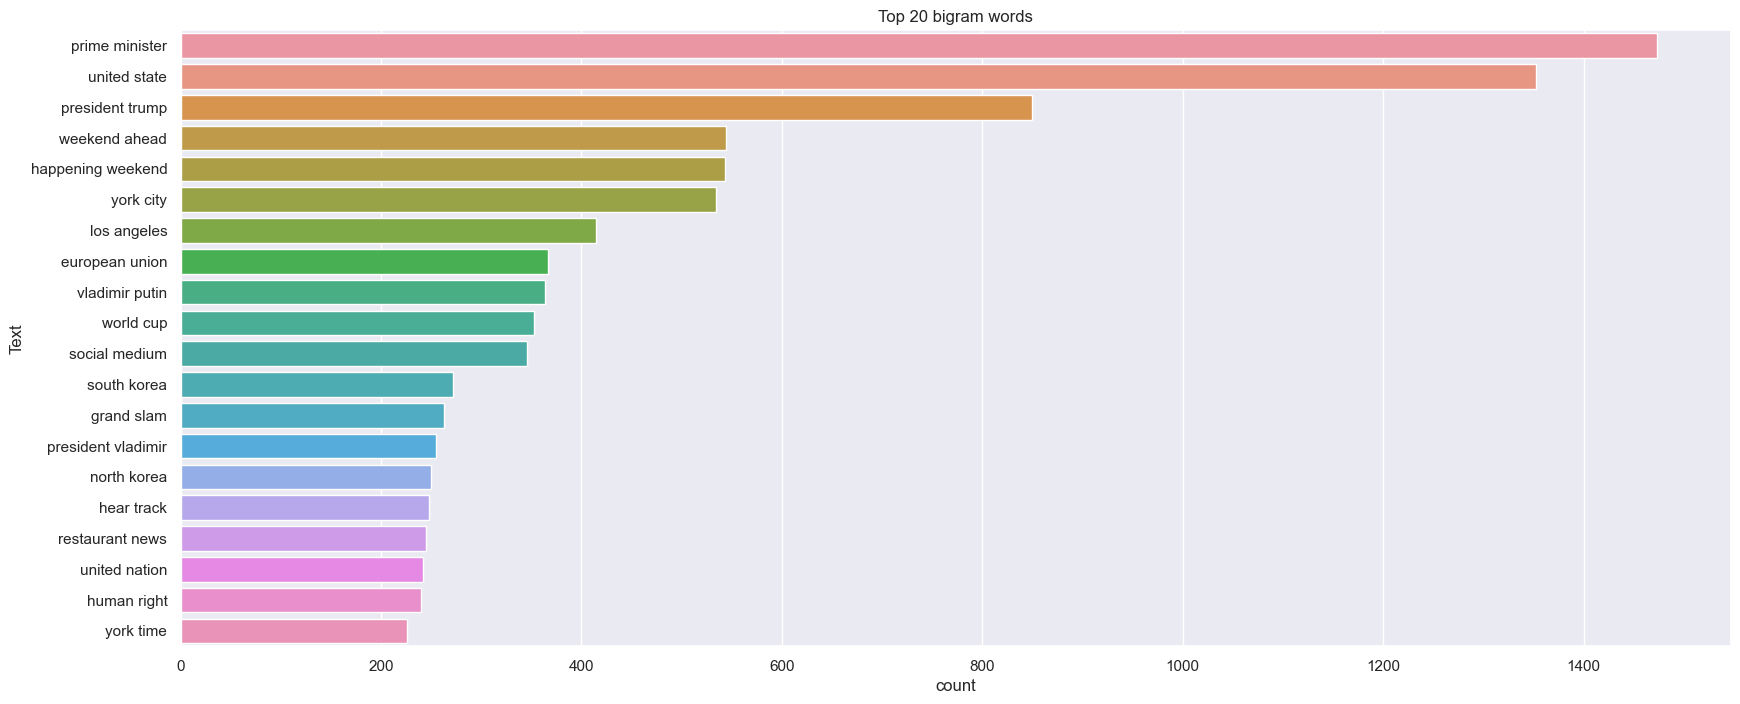

In [47]:
# get top 20 bigram words using function
common_words = get_top_n_gram(data1['abstract'],ngram=2)

# creates dataframe from list of tuples 
df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale = 1)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df1,ax=ax).set(title='Top 20 bigram words')

[Text(0.5, 1.0, 'Top 20 trigram words')]

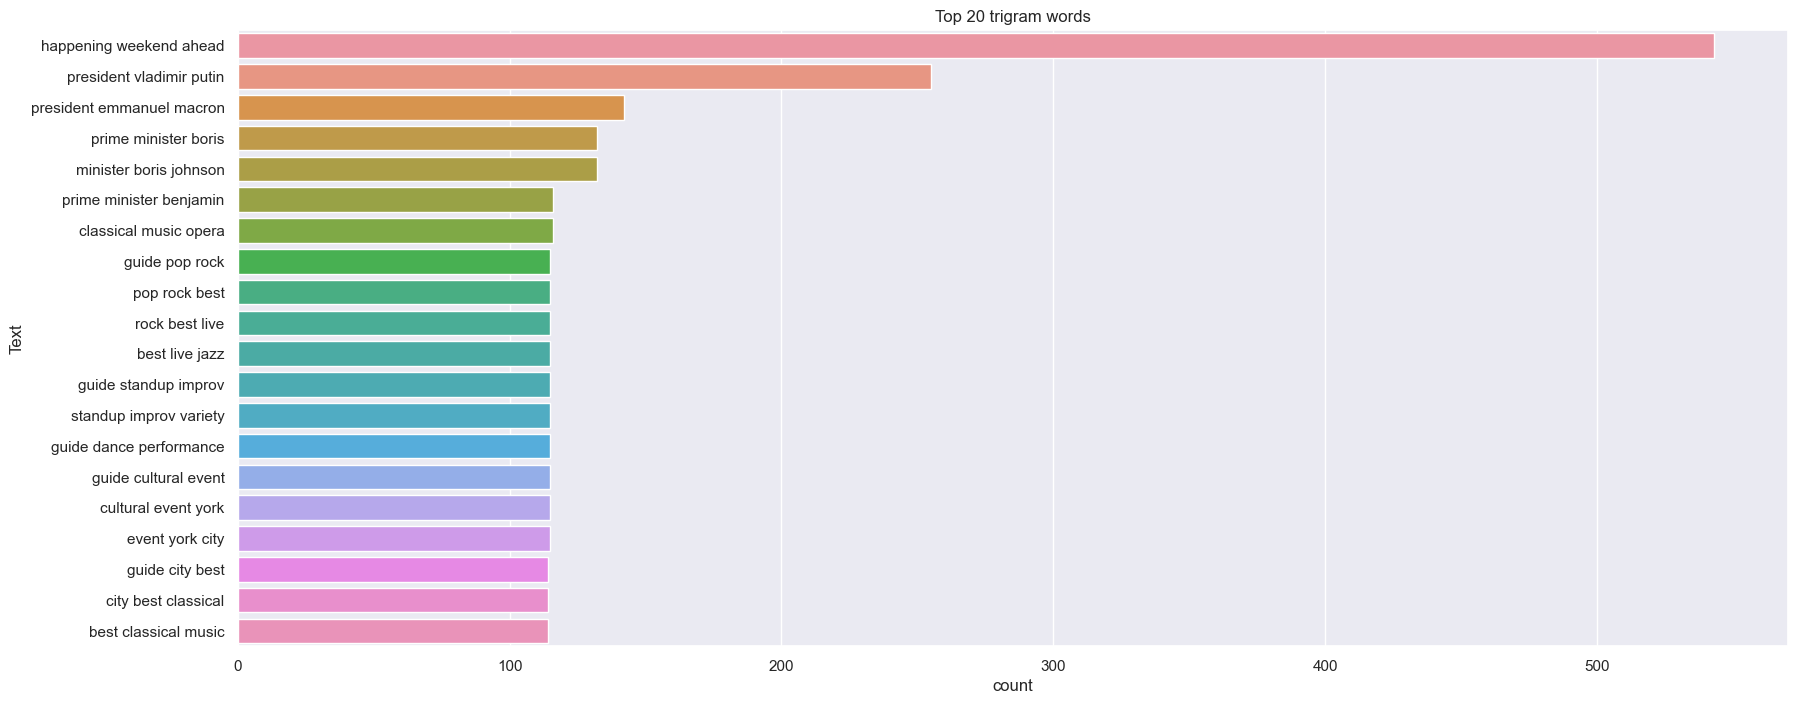

In [48]:
# get top 20 trigram words using function
common_words = get_top_n_gram(data1['abstract'],ngram=3)

# creates dataframe from list of tuples 
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

# plot top 20 words
sns.set(font_scale = 1)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(y= 'Text',x = 'count',data = df2,ax=ax).set(title='Top 20 trigram words')

#### Most Frequent words in the corpus show in wordcloud

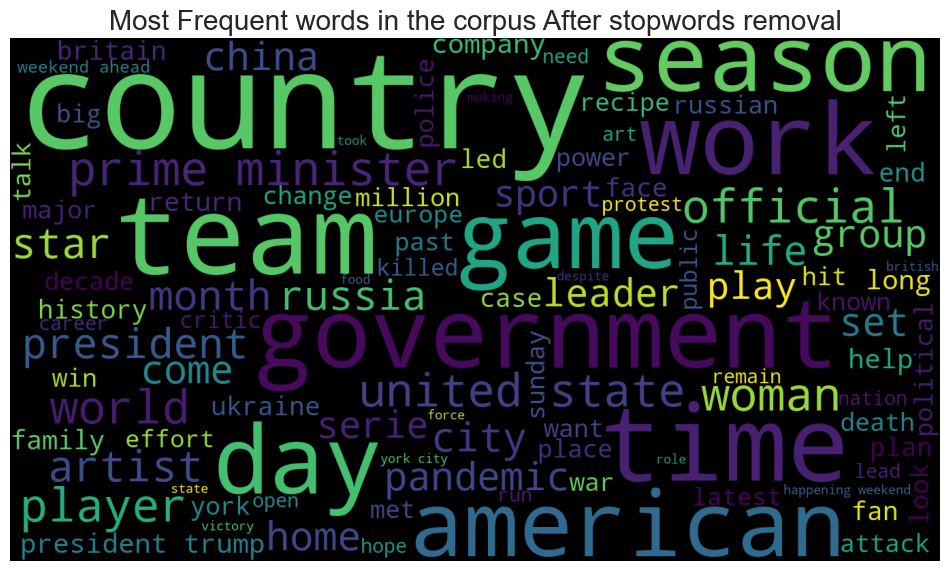

In [49]:
#Most Frequent words in the corpus (abstract) show in wordcloud
freq_words = ','.join(list(data1['abstract'].values))

wordcloud = WordCloud(width=1366, height=768, random_state=42,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Most Frequent words in the corpus After stopwords removal',size=20)
plt.axis('off')
plt.show()

In [50]:
#Data reduction 
after_preprocess=data1['wc_rem_stopword'].sum()
after_preprocess

data_reduce=(after_preprocess/Total_words1)*100
print(f"We have reduced{data_reduce: .02f} percent unnecessary words from our corpus")

We have reduced 52.33 percent unnecessary words from our corpus


In [51]:
data1.shape

(70903, 11)

### Lead Paragraph - Preprocessing

In [52]:
data2 = df.loc[df['section_name']=='Travel']
data2.shape

(2461, 8)

In [53]:
# Getting word count of each lead paragraph
data2['word_count']=data2['lead_paragraph'].apply(word_count) 

In [54]:
#Total number of words present in the whole lead paragraph corpus 
Total_words=sum(data2['word_count'])
Total_words

141241

In [55]:
# Removing punctuations 

import re
data2['lead_paragraph'] = data2['lead_paragraph'].map(lambda x: re.sub('[,\.!?—’]', '', x)) #removing punctuations
data2['lead_paragraph'] = data2['lead_paragraph'].map(lambda x: x.lower()) # our dataset is already lowercase, this is an additional step here

import gensim
from gensim.utils import simple_preprocess

def preprocess_text(text):
    return gensim.utils.simple_preprocess(str(text), deacc=True)  # deacc=True removes punctuations

# gensim.utils.simple_preprocess lowercases, tokenizes, de-accents (optional). – the output are final tokens = unicode strings, that won’t be processed any further.

data2['lead_paragraph'] = data2['lead_paragraph'].apply(preprocess_text)

In [56]:
data2['lead_paragraph'].iloc[0]

['theres',
 'nothing',
 'like',
 'total',
 'absence',
 'of',
 'safety',
 'measures',
 'to',
 'add',
 'little',
 'excitement',
 'to',
 'historical',
 'site',
 'within',
 'an',
 'hour',
 'of',
 'landing',
 'on',
 'la',
 'isla',
 'de',
 'la',
 'juventud',
 'the',
 'isle',
 'of',
 'youth',
 'was',
 'clambering',
 'through',
 'an',
 'underground',
 'tunnel',
 'in',
 'the',
 'presidio',
 'modelo',
 'or',
 'model',
 'prison',
 'cubas',
 'most',
 'dreaded',
 'pre',
 'revolutionary',
 'prison',
 'using',
 'my',
 'iphone',
 'as',
 'torch',
 'and',
 'trying',
 'not',
 'to',
 'slip',
 'on',
 'wooden',
 'planks',
 'and',
 'rubble',
 'after',
 'squeezing',
 'up',
 'rusty',
 'spiral',
 'staircase',
 'emerged',
 'atop',
 'tower',
 'at',
 'the',
 'center',
 'of',
 'an',
 'enormous',
 'circular',
 'cell',
 'building',
 'that',
 'resembled',
 'tropical',
 'colosseum',
 'where',
 'single',
 'guard',
 'would',
 'once',
 'monitor',
 'more',
 'than',
 'prisoners',
 'at',
 'time']

[Text(0.5, 1.0, 'Top 20 most frequent words in the corpus')]

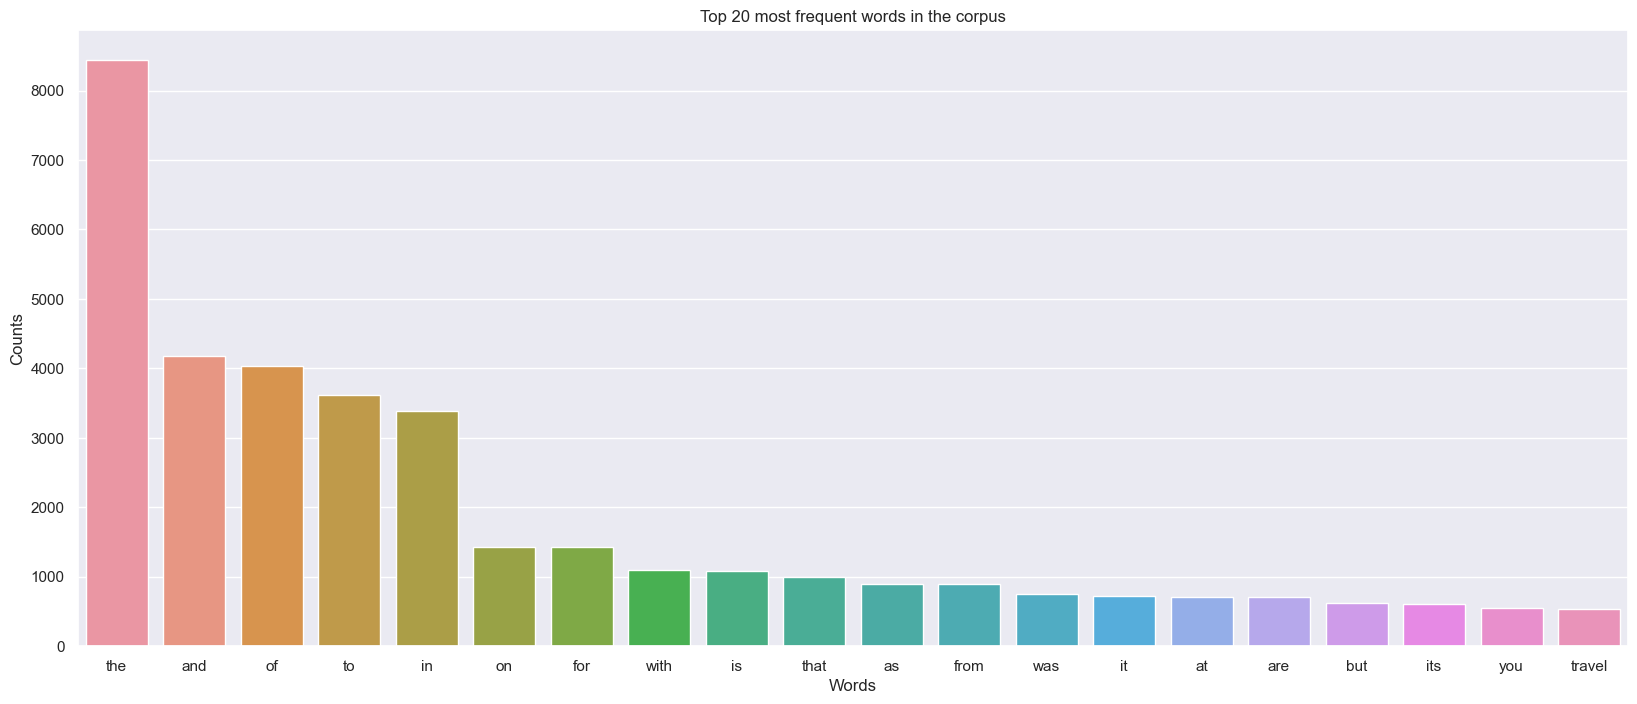

In [57]:
#Top 20 most frequent words in the corpus (lead_paragraph)

Top_20_freq = pd.Series(word for sublist in data2['lead_paragraph'] for word in sublist).value_counts()[:20]
top20=pd.DataFrame()
top20['Words']= list(Top_20_freq.index)
top20['Counts']=list(Top_20_freq.values)

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x = 'Words',y = 'Counts',data = top20,ax=ax).set(title='Top 20 most frequent words in the corpus')

In [58]:
# same for lead_paragraph using another method
# Load the regular expression library
import re

# Remove punctuation
data1['lead_paragraph'] = data1['lead_paragraph'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
data1['lead_paragraph'] = data1['lead_paragraph'].map(lambda x: x.lower())

# Print out the first rows of papers
data1['lead_paragraph'].head()


import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = data1.lead_paragraph.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])


# Build the bigram and trigram models
bigram = gensim.models.Phrases( data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

['in', 'the', 'weeks', 'before', 'their', 'family', 'trip', 'to', 'costa', 'rica', 'bruce', 'and', 'irene', 'steinberg', 'of', 'scarsdsale', 'ny', 'told', 'friends', 'and', 'family', 'how', 'excited', 'they', 'were', 'to', 'take', 'their', 'three', 'sons']


In [59]:
#removing stop_words from lead_paragraph

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Define functions for stopwords, bigrams, trigrams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shiqing\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
try:
    !python -m spacy download en_core_web_sm
    import spacy
except Exception as e:
    print(f"An error occurred during spaCy setup: {e}")

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 656.4 kB/s eta 0:00:20
     - -------------------------------------- 0.6/12.8 MB 4.5 MB/s eta 0:00:03
     --- ------------------------------------ 1.1/12.8 MB 6.4 MB/s eta 0:00:02
     ---- ----------------------------------- 1.5/12.8 MB 6.9 MB/s eta 0:00:02
     ------ --------------------------------- 2.0/12.8 MB 8.0 MB/s eta 0:00:02
     ------- -------------------------------- 2.5/12.8 MB 8.5 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.8 MB 8.9 MB/s eta 0:00:02
     ----------- ---------------------------- 3.6/12.8 MB 9.3 MB/s eta 0:00:01
     ------------- -------------------------- 4.2/12.8 MB 9.2 MB/s eta 0:00:01
     -------------- ------------------------- 4.7/12.8 MB 9.7 MB/s eta 0:00:01
     ---------------- ----------------------- 5.3/12.8 MB 9.6 MB/

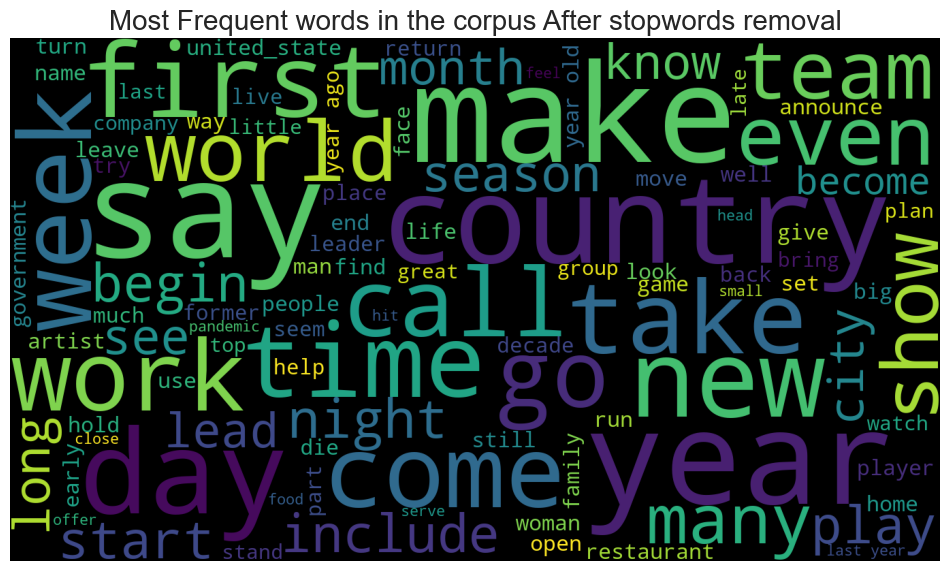

In [61]:
#Most Frequent words in the corpus (lead_paragraph) show in wordcloud
freq_words = ' '.join([' '.join(doc) for doc in data_lemmatized])

wordcloud = WordCloud(width=1366, height=768, random_state=42,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Most Frequent words in the corpus After stopwords removal',size=20)
plt.axis('off')
plt.show()

In [62]:
#removal of non-contextual words from lead_paragraph corpus
add_stopwords= ['say','make','many','take','trip','time','well','day','travel','traveler','know','week','people','year','way','still', 'time']
#Function to remove additional stopwords 
def remove_add_stopwords(words):
    words = [wd.lower() for wd in words if wd.lower() not in add_stopwords]
    return words
# Applying the function to each sublist in data_lemmatized
data_lemmatized = [remove_add_stopwords(doc) for doc in data_lemmatized]

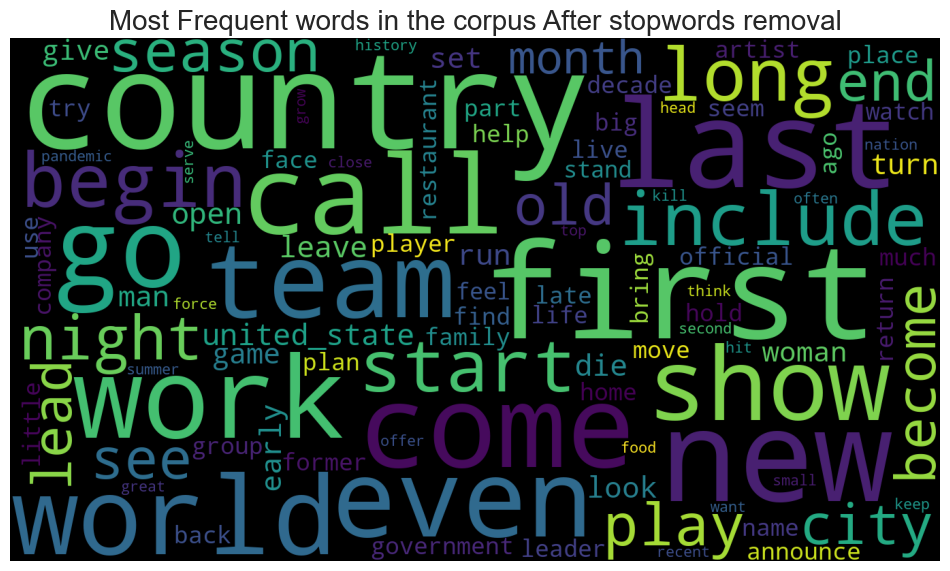

In [63]:
#Most Frequent words in the corpus (lead_paragraph) show in wordcloud
freq_words = ' '.join([' '.join(doc) for doc in data_lemmatized])

wordcloud = WordCloud(width=1366, height=768, random_state=42,max_words=100 ,max_font_size=200,background_color='black').generate(freq_words)
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud)
plt.title('Most Frequent words in the corpus After stopwords removal',size=20)
plt.axis('off')
plt.show()

## Modelling - Latent Dirichlet Allocation

### Term Frequency Inverse Document Frequency (TF-IDF)

In [64]:
#Tf-Idf vectoriser

# min_df = 0.03 means that the words (terms) should appear in at least 3% 
# of the documents to be considered in the TF-IDF matrix. words that appear in 
# less than 3% of the documents will be ignored in the TF-IDF matrix.

vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.03) 
document_term_matrix = vectorizer.fit_transform(data1['abstract'])
#Shape of document term matrix
document_term_matrix.shape

(70903, 12)

In [65]:
print(document_term_matrix) 

  (0, 4)	1.0
  (2, 3)	1.0
  (4, 1)	1.0
  (7, 10)	0.574351265566794
  (7, 9)	0.5678089533471375
  (7, 7)	0.5896724652217111
  (9, 5)	1.0
  (11, 0)	1.0
  (14, 4)	1.0
  (17, 10)	1.0
  (18, 7)	1.0
  (19, 3)	1.0
  (20, 6)	1.0
  (23, 3)	1.0
  (25, 9)	0.560876090645252
  (25, 7)	0.5824726522980759
  (25, 3)	0.5883397150179
  (26, 3)	1.0
  (28, 6)	0.6793277010282507
  (28, 9)	0.7338350459167725
  (31, 1)	1.0
  (32, 6)	1.0
  (35, 0)	0.7212268386885232
  (35, 1)	0.6926989585349171
  (38, 9)	1.0
  :	:
  (70835, 0)	1.0
  (70841, 5)	1.0
  (70843, 2)	1.0
  (70848, 0)	1.0
  (70849, 7)	1.0
  (70851, 5)	1.0
  (70853, 5)	1.0
  (70854, 5)	1.0
  (70855, 10)	1.0
  (70856, 2)	1.0
  (70863, 3)	1.0
  (70864, 1)	1.0
  (70866, 2)	1.0
  (70869, 10)	1.0
  (70876, 1)	1.0
  (70877, 6)	1.0
  (70878, 1)	1.0
  (70884, 4)	1.0
  (70885, 2)	0.6560577004917977
  (70885, 0)	0.7547107350670286
  (70887, 4)	1.0
  (70892, 6)	1.0
  (70899, 6)	0.6590498260366046
  (70899, 5)	0.752099279883395
  (70902, 3)	1.0


In [66]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

done in 28.865s.


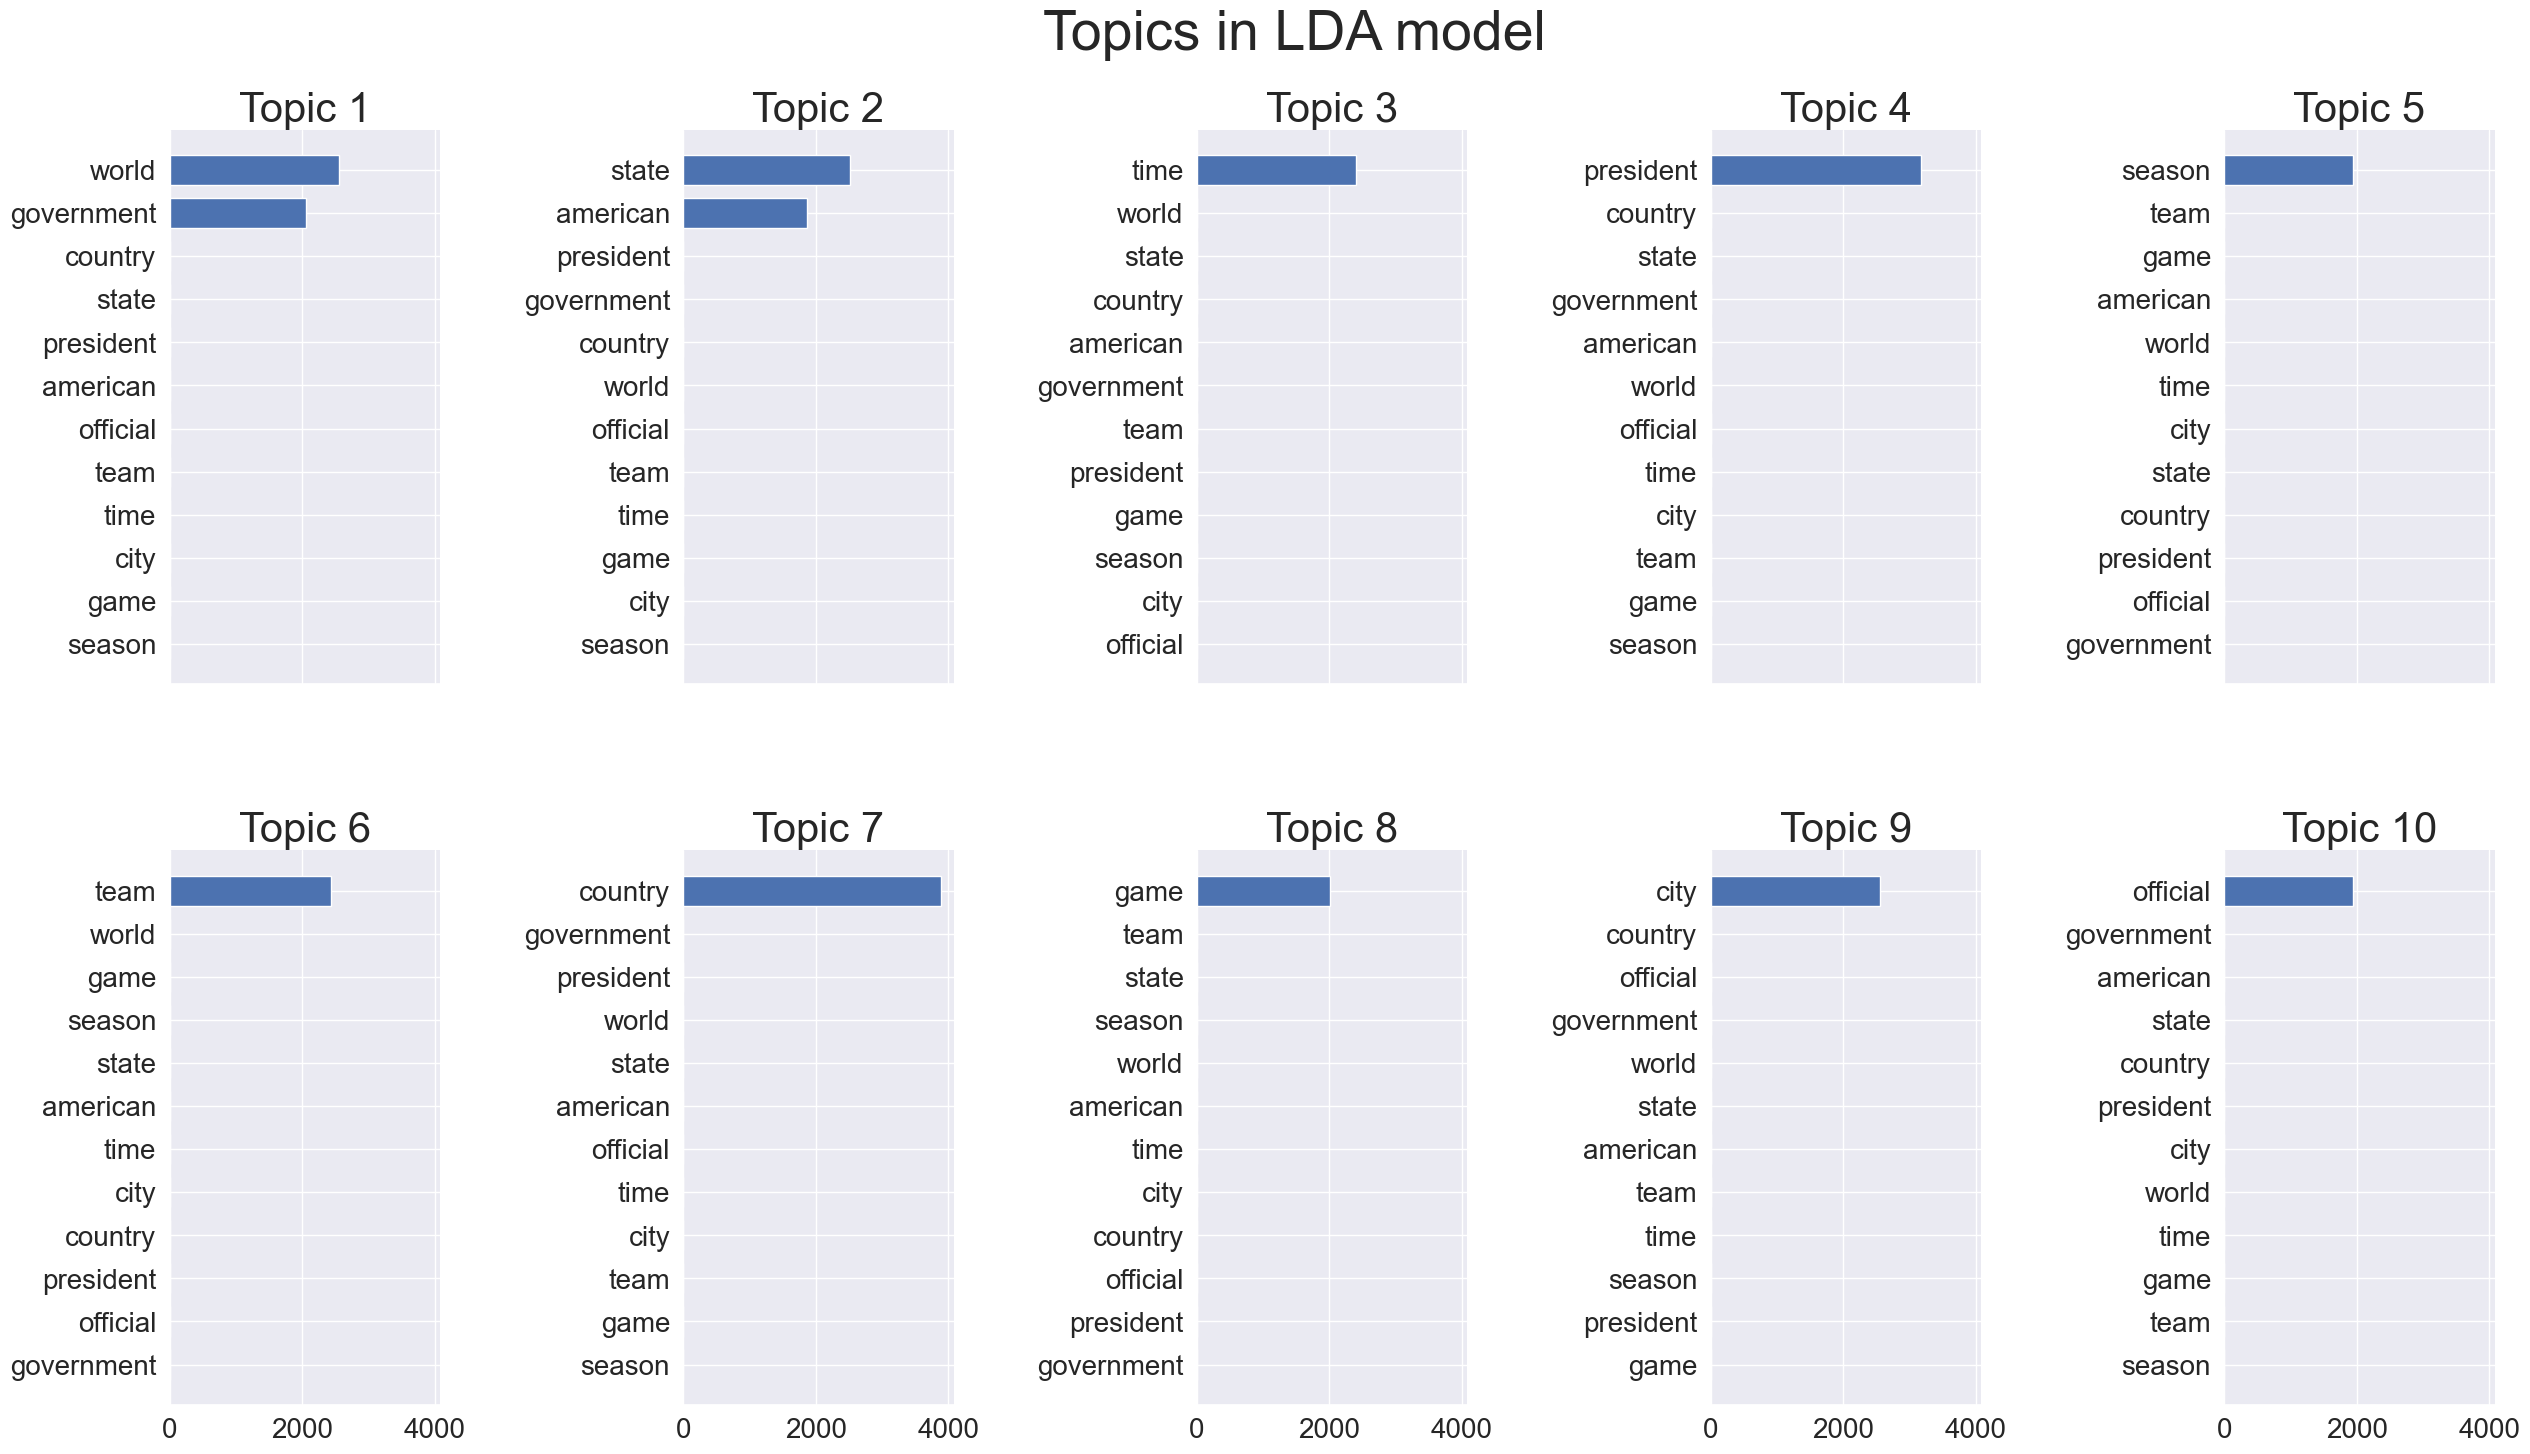

In [67]:
from time import time
lda_model = LatentDirichletAllocation(n_components=10,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=42)

t0 = time()

lda_model.fit(document_term_matrix)

print("done in %0.3fs." % (time() - t0))

tf_feature_names = vectorizer.get_feature_names_out()

plot_top_words(lda_model, tf_feature_names, 20, "Topics in LDA model")

In [68]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(5,10))}

# LDA model
lda_model = GridSearchCV(LatentDirichletAllocation(learning_method ='online', random_state=42),param_grid=grid_params)
lda_model.fit(document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(document_term_matrix))

Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -15525.220490361831
LDA model Perplexity on train data 14.315647759400864


In [69]:
# LDA model fitting for best parameter
lda= LatentDirichletAllocation(n_components=5,learning_method ='online',max_iter=10,random_state=42, n_jobs=-1)
lda.fit(document_term_matrix)

LatentDirichletAllocation(learning_method='online', n_components=5, n_jobs=-1,
                          random_state=42)

In [70]:
# LDA model
top_lda=lda.fit_transform(document_term_matrix)

print(top_lda.shape)
print(top_lda)

(70903, 5)
[[0.59999997 0.10000001 0.1        0.10000001 0.10000001]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.10000001 0.59999996 0.10000001 0.10000001 0.10000001]
 ...
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.10000001 0.59999996 0.10000001 0.10000001 0.10000001]]


In [71]:
# composition of doc 0 for eg
print("Document 0: ")
for i,topic in enumerate(top_lda[0]):
  print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  59.99999742249101 %
Topic  1 :  10.000000590843424 %
Topic  2 :  10.000000474677783 %
Topic  3 :  10.00000067340486 %
Topic  4 :  10.000000838582912 %


In [72]:
print("""The first document is more belonging to the Topic 1.""")

The first document is more belonging to the Topic 1.


In [73]:
#lda for lead_paragraph

import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]


In [74]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [75]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.46066693577523415


In [76]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

NB: The code below works but need long time to run, since we use large dataset. So we note it in case stop kernal by run automatically.

In [77]:
# import numpy as np
# import tqdm

# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # Validation sets
# num_of_docs = len(corpus)
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
#                corpus]

# corpus_title = ['75% Corpus', '100% Corpus']

# model_results = {'Validation_Set': [],
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
#     # iterate through validation corpuses
#     for i in range(len(corpus_sets)):
#         # iterate through number of topics
#         for k in topics_range:
#             # iterate through alpha values
#             for a in alpha:
#                 # iterare through beta values
#                 for b in beta:
#                     # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
#                                                   k=k, a=a, b=b)
#                     # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a)
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
                    
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pbar.close()    

In [78]:
num_topics = 8

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.01,
                                           eta=0.9)

In [79]:
# import pyLDAvis.gensim_models as gensimvis
# import pickle 
# import pyLDAvis
# import os 
# # Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_data_filepath = os.path.join('./results/ldavis_tuned_'+str(num_topics))

# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)

# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)

# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_tuned_'+ str(num_topics) +'.html')

# LDAvis_prepared

In [80]:
import pyLDAvis.lda_model
lda_panel = pyLDAvis.lda_model.prepare(best_lda_model, document_term_matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      37.461403 -17.047058       1        1  26.087777
1      37.697826 -39.177448       2        1  21.354136
4      24.385210 -56.859299       3        1  17.658389
0       7.892893 -40.984547       4        1  17.560085
3      14.761150 -20.015472       5        1  17.339612, topic_info=          Term         Freq        Total Category  logprob  loglift
1         city  2844.000000  2844.000000  Default  12.0000  12.0000
9         team  2801.000000  2801.000000  Default  11.0000  11.0000
11       world  2793.000000  2793.000000  Default  10.0000  10.0000
2      country  3034.000000  3034.000000  Default   9.0000   9.0000
4   government  2288.000000  2288.000000  Default   8.0000   8.0000
..         ...          ...          ...      ...      ...      ...
8        state     0.231240  2442.037963   Topic5  -9.9853  -7.5127
6    president     0.231170  2596.928743   Topic5  -9.9856  -7.5745
11       world     0.230945  2793.931563   Topic5  -9.9866  -7.6486
1         city     0.230893  2844.626562   Topic5  -9.9868  -7.6668
2      country     0.231204  3034.187495   Topic5  -9.9855  -7.7300

[72 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.999509    american
1         3  0.999780        city
2         1  0.999609     country
3         2  0.999507        game
4         4  0.999857  government
5         5  0.999467    official
6         1  0.999642   president
7         3  0.999536      season
8         2  0.999575       state
9         5  0.999583        team
10        1  0.999317        time
11        4  0.999667       world, R=12, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

In [81]:
# most important words for each topic
vocab = vectorizer.get_feature_names_out()

Topic 0


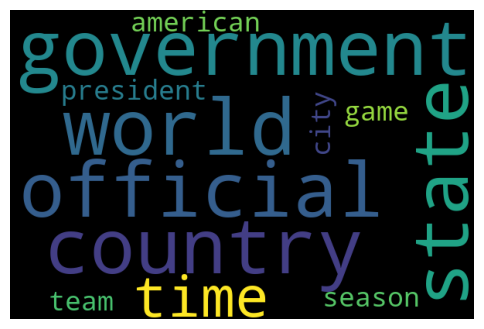

In [82]:
from wordcloud import WordCloud
# Generate a word cloud image for given topic
def word_cloud_lda(index):
  imp_words_topic=""
  comp=lda.components_[index]
  vocab_comp = zip(vocab, comp)
  sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
  for word in sorted_words:
    imp_words_topic=imp_words_topic+" "+word[0]

  wordcloud = WordCloud(width=600, height=400,max_font_size=100).generate(imp_words_topic)
  plt.figure( figsize=(5,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout()
  plt.show()
#Word Cloud for each topic
print("""Topic 0""")
word_cloud_lda(0)

Topic 1


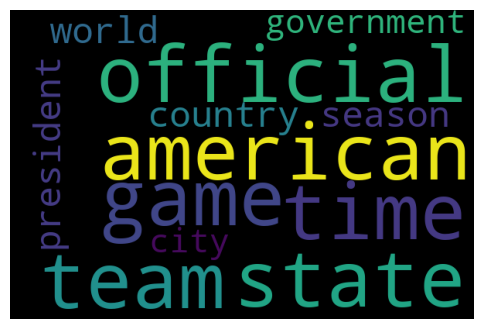

In [83]:
print("""Topic 1""")
word_cloud_lda(1)

Topic 2


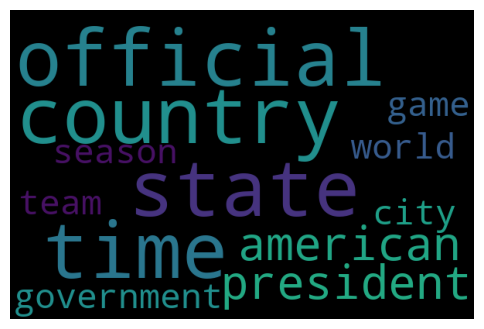

In [84]:
print("""Topic 2""")
word_cloud_lda(2)

Topic 3


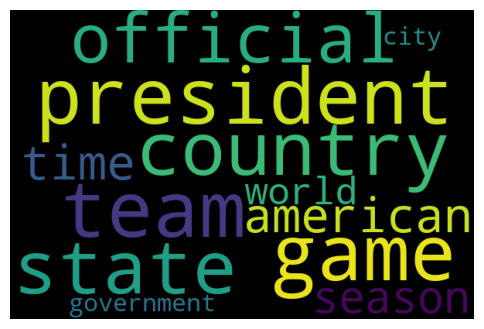

In [85]:
print("""Topic 3""")
word_cloud_lda(3) 

Topic 4


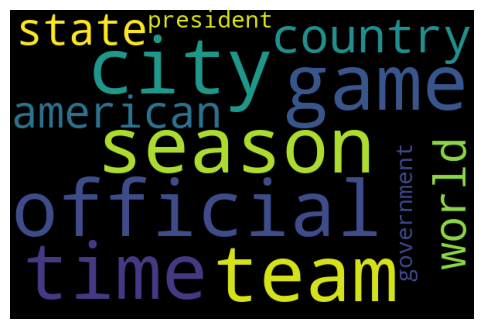

In [86]:
print("""Topic 4""")
word_cloud_lda(4) 

There are 5 different topic present in the aricles.

LDA and LSA are implemented to find the hidden topics.

LDA performs well & shows 5 different clusters present in the Corpus.